In [46]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [47]:
# Define device globally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
# Step 1: Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers - compress the image
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),    # Input image (784) -> 128 neurons
            nn.ReLU(),
            nn.Linear(128, 64),       # 128 -> 64 neurons
            nn.ReLU(),
            nn.Linear(64, 32),        # 64 -> 32 neurons (compressed representation)
            nn.ReLU()
        )

        # Decoder layers - reconstruct the image
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),        # 32 -> 64 neurons
            nn.ReLU(),
            nn.Linear(64, 128),       # 64 -> 128 neurons
            nn.ReLU(),
            nn.Linear(128, 28*28),    # 128 -> Output image (784)
            nn.Sigmoid()              # Keep values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [49]:
# Step 2: Prepare the MNIST dataset
def load_data():
    # Define the data transformations
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Load MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    return train_loader

In [50]:
# Step 3: Training function
def train_autoencoder(model, train_loader, epochs=10):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)  # Flatten the images

            # Add noise to the input images
            noise_factor = 0.3
            noisy_img = img + noise_factor * torch.randn_like(img)
            noisy_img = torch.clamp(noisy_img, 0., 1.)

            # Forward pass
            output = model(noisy_img)
            loss = criterion(output, img)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')


In [51]:
# Step 4: Visualize results
def visualize_results(model, train_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(train_loader))
        images = images[:10].to(device)  # Move images to device

        # Add noise
        noisy_images = images + 0.3 * torch.randn_like(images)
        noisy_images = torch.clamp(noisy_images, 0., 1.)

        # Get denoised images
        noisy_images_flat = noisy_images.view(noisy_images.size(0), -1)
        denoised_images = model(noisy_images_flat)
        denoised_images = denoised_images.view(images.shape)

        # Move tensors back to CPU for plotting
        images = images.cpu()
        noisy_images = noisy_images.cpu()
        denoised_images = denoised_images.cpu()

        # Plot results
        plt.figure(figsize=(15, 5))
        for i in range(10):
            # Original image
            plt.subplot(3, 10, i + 1)
            plt.imshow(images[i][0], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Original')

            # Noisy image
            plt.subplot(3, 10, i + 11)
            plt.imshow(noisy_images[i][0], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Noisy')

            # Denoised image
            plt.subplot(3, 10, i + 21)
            plt.imshow(denoised_images[i][0], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Denoised')

        plt.tight_layout()
        plt.show()

Epoch [1/10], Average Loss: 0.0659
Epoch [2/10], Average Loss: 0.0389
Epoch [3/10], Average Loss: 0.0306
Epoch [4/10], Average Loss: 0.0265
Epoch [5/10], Average Loss: 0.0242
Epoch [6/10], Average Loss: 0.0227
Epoch [7/10], Average Loss: 0.0216
Epoch [8/10], Average Loss: 0.0207
Epoch [9/10], Average Loss: 0.0200
Epoch [10/10], Average Loss: 0.0194


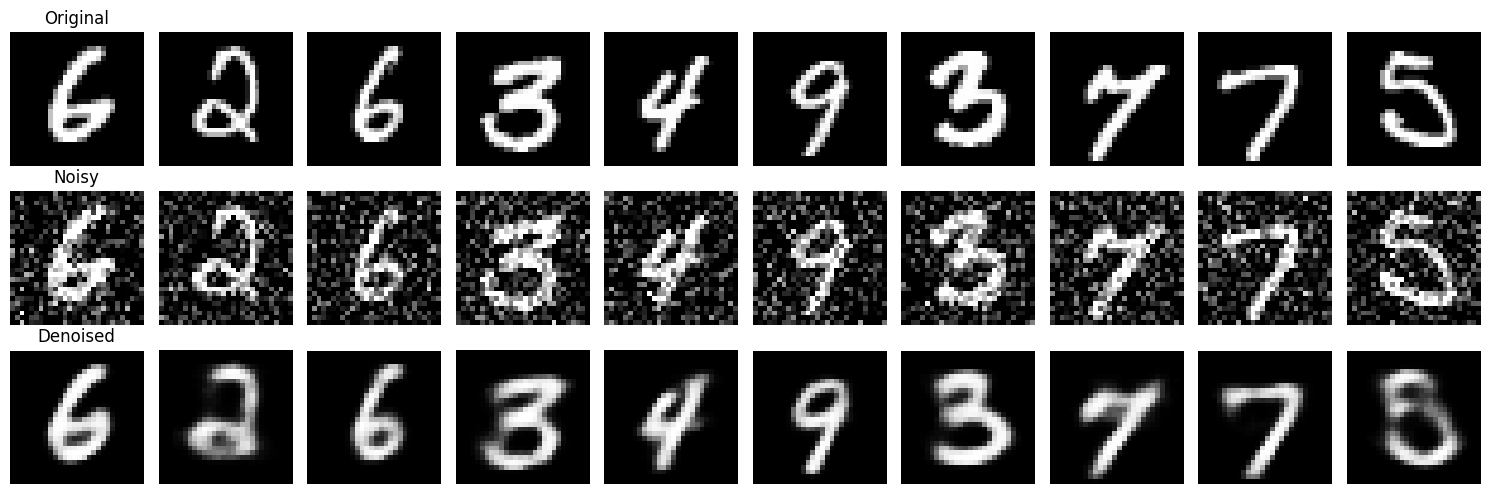

In [52]:
# Step 5: Main execution
if __name__ == "__main__":
    # Create model and load data
    model = Autoencoder().to(device)  # Move model to device immediately
    train_loader = load_data()

    # Train the model
    train_autoencoder(model, train_loader, epochs=10)

    # Visualize results
    visualize_results(model, train_loader)